**Imports**

In [ ]:
!pip install pandas textblob
!pip install scikit-learn
!pip install vaderSentiment
import nltk
nltk.download('punkt')
import nltk
nltk.download('vader_lexicon')
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

&nbsp;

**TestBlob Sentiment Analysis + Histograms**

sentiment,Negative,Neutral,Positive
#trump,15.87,54.57,29.57
#russia,17.07,52.77,30.16
#zelenskyy,13.86,48.02,38.12
#putin,17.46,51.85,30.69
#nafo,9.25,38.73,52.02


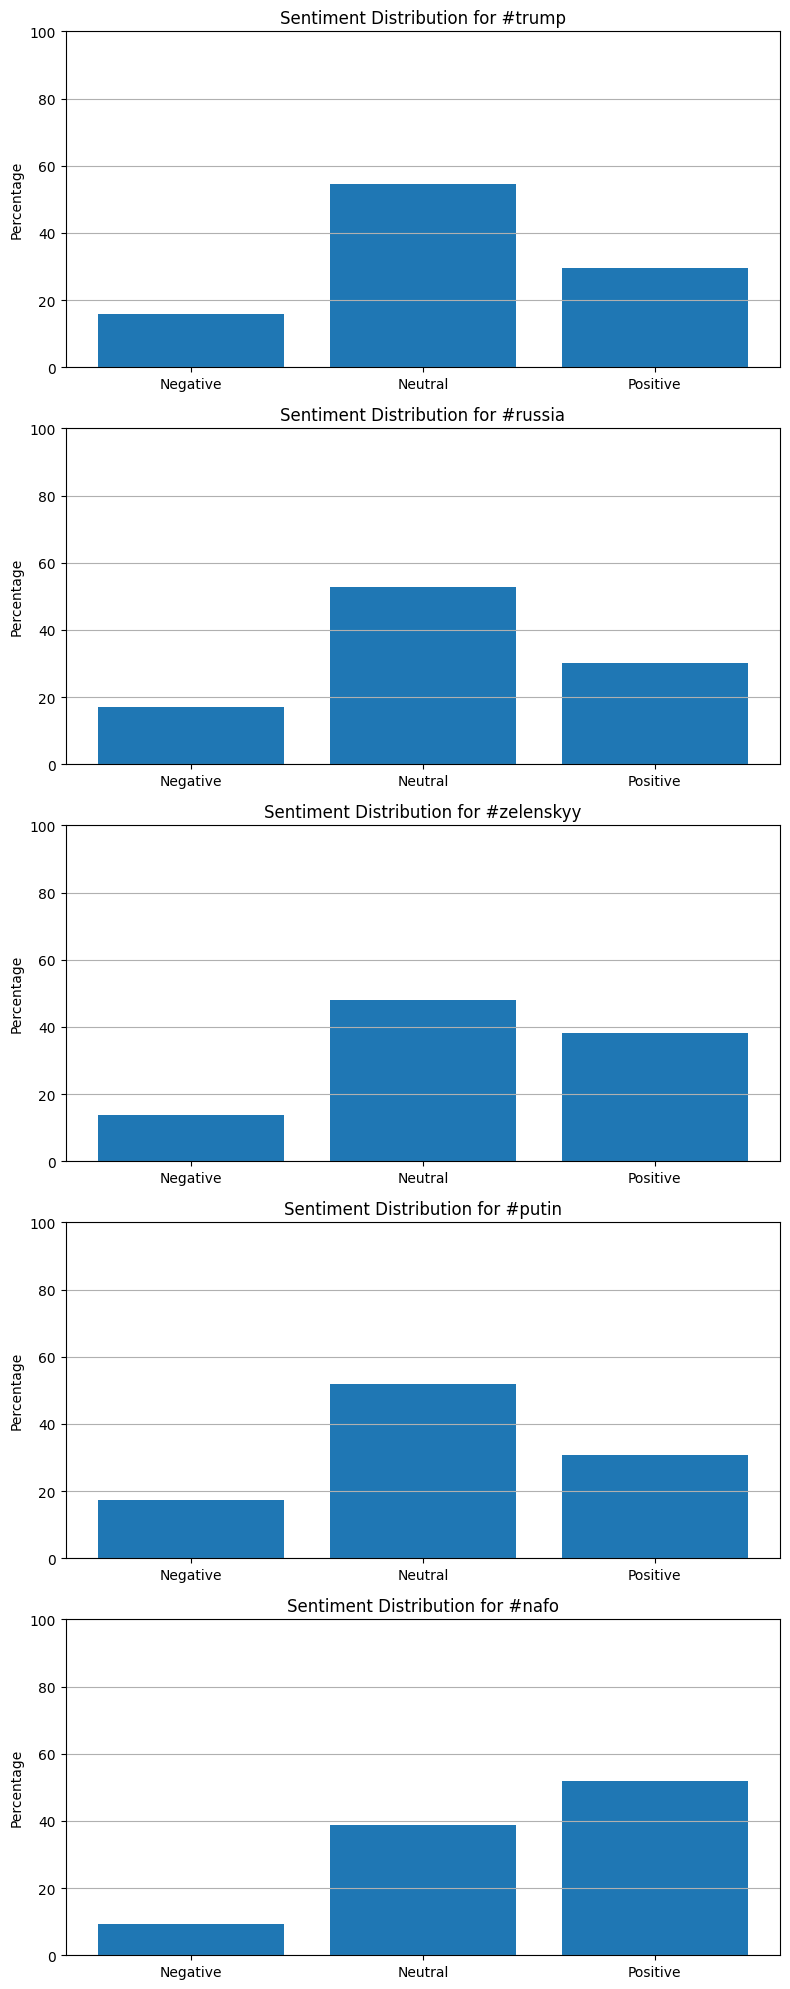

In [ ]:
import re
import pandas as pd
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display  # For rich table display

# --- Setup ---

# Download stopwords if needed
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# --- Helper Functions ---

def preprocess_text(text):
    """Lowercase, remove non-alphabetic chars, and strip stopwords."""
    text = re.sub(r'[^a-z\s]', '', text.lower())
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

def extract_hashtags(text, exclude="#ukraine"):
    """Extract hashtags (excluding a specified one) from text."""
    return [tag.lower() for tag in re.findall(r"#\w+", text) if tag.lower() != exclude.lower()]

def classify_sentiment(polarity):
    """Return sentiment label based on polarity score."""
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    return 'Neutral'

# --- Main Processing ---

# Load and preprocess
data = pd.read_json("Devon-Boldt-bluesky.json")
data['clean_text'] = data['text'].apply(preprocess_text)
data['polarity'] = data['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['sentiment'] = data['polarity'].apply(classify_sentiment)
data['hashtags'] = data['text'].apply(extract_hashtags)

# Flatten hashtags and get top 5 (excluding '#ukraine')
all_tags = [tag for tags in data['hashtags'] for tag in tags]
top_tags = Counter(all_tags).most_common(5)
top_tag_names = [tag for tag, _ in top_tags]

# Analyze sentiment distribution per tag
tag_sentiments = {}
for tag in top_tag_names:
    tagged_subset = data[data['hashtags'].apply(lambda tags: tag in tags)]
    sentiment_distribution = tagged_subset['sentiment'].value_counts(normalize=True) * 100
    tag_sentiments[tag] = sentiment_distribution

# Create sentiment DataFrame
tag_sentiment_df = pd.DataFrame(tag_sentiments).fillna(0).T  # Tags as rows

# --- Display Styled Table ---

styled_df = (
    tag_sentiment_df.round(2)
    .style.set_caption("Sentiment Distribution Table (%)")
    .background_gradient(cmap="coolwarm", axis=None)
    .format("{:.2f}")
)

display(styled_df)

# --- Plotting ---

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))
for i, tag in enumerate(tag_sentiment_df.index):
    sentiments = tag_sentiment_df.loc[tag]
    axes[i].bar(sentiments.index, sentiments.values)
    axes[i].set_title(f'Sentiment Distribution for {tag}')
    axes[i].set_ylabel('Percentage')
    axes[i].set_ylim(0, 100)
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()


&nbsp;

**Top 5 Positive / Negative / Neutral Tweets + Scores**

In [ ]:
import re
import pandas as pd
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from IPython.display import display  # For styled tables

# --- Setup ---

# Ensure stopwords are available
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# --- Helper Functions ---

def preprocess_text(text):
    """Lowercase, remove non-alphabetic characters, and strip stopwords."""
    text = re.sub(r'[^a-z\s]', '', text.lower())
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

def classify_sentiment(polarity):
    """Classify sentiment polarity into positive, negative, or neutral."""
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    return 'neutral'

def highlight_category(row):
    """Apply background color based on sentiment category."""
    color_map = {
        'Top-5 Positive': '#d4edda',  # light green
        'Top-5 Negative': '#f8d7da',  # light red
        'Top-5 Neutral':  '#fff3cd',  # light yellow
    }
    return [f'background-color: {color_map.get(row["category"], "")}'] * len(row)

# --- Main Processing ---

# Load and preprocess data
data = pd.read_json("Devon-Boldt-bluesky.json")
data['clean_text'] = data['text'].apply(preprocess_text)

# Analyze sentiment
data['polarity'] = data['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['sentiment'] = data['polarity'].apply(classify_sentiment)

# Extract top 5 from each sentiment category
def top_n_by_sentiment(df, sentiment, n=5):
    df_sent = df[df['sentiment'] == sentiment]
    if sentiment == 'positive':
        top = df_sent.nlargest(n, 'polarity')
    elif sentiment == 'negative':
        top = df_sent.nsmallest(n, 'polarity')
    else:  # neutral
        top = df_sent.sort_values(by='polarity', ascending=False).head(n)
    top = top[['text', 'polarity']].copy()
    top['category'] = f'Top-5 {sentiment.capitalize()}'
    return top

top_positive = top_n_by_sentiment(data, 'positive')
top_negative = top_n_by_sentiment(data, 'negative')
top_neutral = top_n_by_sentiment(data, 'neutral')

# Combine and style
top_combined = pd.concat([top_positive, top_negative, top_neutral], ignore_index=True)

styled_top_combined = (
    top_combined.style
    .apply(highlight_category, axis=1)
    .set_caption("Top 5 Sentiment Posts with Highlighted Categories")
    .format({'polarity': '{:.2f}'})
)

# Display results
display(styled_top_combined)


,text,polarity,category
0,If #Russia and the #Serbian government are Mordor... then that means #Ukraine is Rivendell. But it also means that #Serbian opposition... is Gondor and Rohan. And that tracks perfectly.,1.00,Top-5 Positive
1,"ISW: 🇺🇲 Witkoff's statements undermine Trump's stated desired end state for the war in #Ukraine that achieves an enduring peace and is in the best interests of the United States, Ukraine, and Europe. www.understandingwar.org/backgrounder... #USA #Russia",1.00,Top-5 Positive
2,"Zelenskyy: Ukraine leads in drone production—fast, cost-effective, and battle-tested. We are the most efficient in Europe or among the best. Together, we can do even more. 12/12 #Ukraine #RussiaIsATerroristState",1.00,Top-5 Positive
3,#Trump declares he and #Putin will discuss how to best divide #Ukraine’s assets and resources. Neither Trump or Putin have any say on Ukraine's sovereignty. Source: www.itv.com/news/2025-03... #Ukraine #RussiaIsATerroristState #TrumpIsARussianAsset #FuckTrump #StandWithUkraine #TrumpShamesAmerica,1.00,Top-5 Positive
4,Inspired by @tardate.bsky.social posting his excellent build of the same kit and seeing the Ukrainian USV kits from Andrew's Ukraine sea drones being offered as prizes I thought I would share my take on the MikroMir USV on the #ForUkrainegb feed #scalemodels #histscalemodels #boats #ukraine,1.00,Top-5 Positive
5,This is #Odesa tonight. *crickets* from #Trump admin as Russia pummels #Ukraine in a devastating post-ceasefire kamikaze drone attack www.mirror.co.uk/news/world-n...,-1.00,Top-5 Negative
6,"Imagine spending 3 years putting Russia up against the ropes, only to have Trump come in, blow Putin, take a face shot, and throw #Ukraine under he bus. Ukraine had all the power before the worst negotiator of all time stole the election.",-1.00,Top-5 Negative
7,"In our worst nightmares did we ever imagine we would bear witness to the decimation of a nation? I purr for #Ukraine and all of her people, for an end to the destruction and loss of life Purr purr purr #Purrs4Peace",-1.00,Top-5 Negative
8,"I absolutely am disgusted by the president and vice president and denounce their treachery to both #Democracy and our national interest, not to mention #Ukraine. 🇺🇦",-1.00,Top-5 Negative
9,"Mr. #Zelensky, you have conducted yourself with dignity and resolve throughout this horrific situation. I will support you and #Ukraine in whatever way I can. #FireTrump",-1.00,Top-5 Negative


&nbsp;

**2(0) examples of tweets where neutral score is higher than positive or negative**

In [ ]:
import re
import pandas as pd
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from IPython.display import display  # Required to show styled DataFrame

# Ensure stopwords are available
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# --- Helper Functions ---

def preprocess_text(text):
    """Lowercase, remove non-alphabetic characters, and remove stopwords."""
    text = re.sub(r'[^a-z\s]', '', text.lower())
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

def get_sentiment_scores(text):
    """Return sentiment scores as (neutral, positive, negative)."""
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    if polarity > 0:
        return 0.5 - subjectivity / 2, polarity, 0.0
    elif polarity < 0:
        return 0.5 - subjectivity / 2, 0.0, abs(polarity)
    else:
        return 1.0, 0.0, 0.0

def highlight_dominant(row):
    """Highlight dominant sentiment with color."""
    max_score = max(row['neutral_score'], row['positive_score'], row['negative_score'])
    colors = []

    for col in ['neutral_score', 'positive_score', 'negative_score']:
        if row[col] == max_score:
            color = {
                'neutral_score': '#fff3cd',  # yellow
                'positive_score': '#d4edda',  # green
                'negative_score': '#f8d7da'   # red
            }[col]
            colors.append(f'background-color: {color}')
        else:
            colors.append('')
    return [''] + colors  # leave text column uncolored

# --- Main Processing ---

# Load and preprocess data
data = pd.read_json("Devon-Boldt-bluesky.json")
data['clean_text'] = data['text'].apply(preprocess_text)

# Compute sentiment scores
sentiment_scores = data['clean_text'].apply(lambda x: pd.Series(get_sentiment_scores(x)))
sentiment_scores.columns = ['neutral_score', 'positive_score', 'negative_score']
data = pd.concat([data, sentiment_scores], axis=1)

# Filter and display top 20 neutral-dominant tweets
neutral_df = data[
    (data['neutral_score'] > data['positive_score']) &
    (data['neutral_score'] > data['negative_score'])
][['text', 'neutral_score', 'positive_score', 'negative_score']].head(20)

# Apply and display styled DataFrame
styled_neutral = (
    neutral_df.style
    .apply(highlight_dominant, axis=1)
    .set_caption("Top Neutral-Dominant Tweets with Highlighted Sentiment Scores")
    .format({'neutral_score': '{:.2f}', 'positive_score': '{:.2f}', 'negative_score': '{:.2f}'})
)

display(styled_neutral)


,text,neutral_score,positive_score,negative_score
1,"Zelenskyy criticized insufficient pressure on russia, noting ongoing strikes on #Ukraine, including missile and drones. He reported over 1,460 guided bombs and 670 drones launched in a week, targeting civilians. #Zelenskyy urged continued international pressure for security and peace.",1.00,0.00,0.00
3,🇺🇦💃 #model Viesta #fineart #fineartnude #artnude #artisticnude #ukraine #noflash #nudephotography #nudeart #nude #nudemodel #nudeartphotography #portrait #artisticnude #nudeartmodel,1.00,0.00,0.00
5,"🧵1/3 President #Zelenskyy 💬 ""Meeting of our military with the Chiefs of Defence Staff of our partners: Admiral Anthony Radakin from the United Kingdom and General Thierry Bourcart from France. We are making efforts to ensure security in #Ukraine and reliable security guarantees.",0.35,0.00,0.02
6,"🧵1/2 On the night of 6 April 2025, the russia launched a combined attack on #Ukraine with air-, land-, & sea-based missiles and attack UAVs using 132 air attack vehicles, including 23 missiles and 109 UAVs.",1.00,0.00,0.00
7,For every dead and injured Ukrainian a russian must suffer. #Ukraine #UkrainianView,0.40,0.00,0.10
8,"If Russia continues to stall and reject peace, decisive action must follow – Macron #Ukraine",0.45,0.10,0.00
11,"My weekly update has just been published. It includes today's major Russian missile strike on #Kyiv and other cities, peace negotiations, peacekeeping forces, fighting on the eastern front in #Ukraine & China's snap joint exercise around Taiwan. mickryan.substack.com/p/the-big-fi...",0.38,0.03,0.00
12,"18-year-old escapes russian-occupied Luhansk in search of “Ukraine and freedom” Ivan Sarancha was just 15 when russia launched its full-scale invasion of #Ukraine but he understood the lies that russia was telling, about Mariupol and Bucha, and understood that he stood with Ukraine",1.00,0.00,0.00
14,Don’t drink and drive. Explosive combination. #russianLosses #Ukraine,1.00,0.00,0.00
15,A minute of silence at the playground near the site of the tragedy in Kryvyi Rih. People are bringing flowers and toys. Russia knowingly bombed this popular neighborhood playground. Several children were killed. #Ukraine #RussiaIsATerroristState #TrumpIsARussianAsset,0.34,0.12,0.00


&nbsp;

**Finding Sentiment Score of Each Tweet**

**NOTE:** At the bottom, I calculated the totals for the tweets / sentiments

In [ ]:
import pandas as pd
from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords
from IPython.display import display

# Download stopwords if not already present
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define sentiment colors
SENTIMENT_COLORS = {
    'positive': '#d4edda',  # light green
    'negative': '#f8d7da',  # light red
    'neutral':  '#fff3cd',  # light yellow
}

def preprocess_text(text):
    """Lowercase, remove punctuation, and strip stopwords."""
    text = re.sub(r'[^a-z\s]', '', text.lower())
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

def get_sentiment_label(text):
    """Classify sentiment as positive, negative, or neutral."""
    polarity = TextBlob(text).sentiment.polarity
    return 'positive' if polarity > 0 else 'negative' if polarity < 0 else 'neutral'

def highlight_sentiment(row, sentiment_col='sentiment'):
    """Apply background color based on sentiment."""
    color = SENTIMENT_COLORS.get(row[sentiment_col], '')
    return [f'background-color: {color}'] * len(row)

def style_dataframe(df, caption, sentiment_col='sentiment'):
    """Return a styled DataFrame with sentiment highlights."""
    return df.style.apply(lambda row: highlight_sentiment(row, sentiment_col), axis=1)\
                   .set_caption(caption)

def main():
    # Load and process data
    data = pd.read_json("Devon-Boldt-bluesky.json")
    data['clean_text'] = data['text'].apply(preprocess_text)
    data['sentiment'] = data['clean_text'].apply(get_sentiment_label)

    # Show styled tweet DataFrame
    tweet_df = data[['text', 'clean_text', 'sentiment']]
    display(style_dataframe(tweet_df, "All Tweets with Sentiment Coloring"))

    # Show sentiment summary
    summary_df = data['sentiment'].value_counts().reindex(['positive', 'negative', 'neutral'], fill_value=0).reset_index()
    summary_df.columns = ['Sentiment', 'Count']
    display(style_dataframe(summary_df, "Tweet Sentiment Summary", sentiment_col='Sentiment'))

if __name__ == "__main__":
    main()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Sentiment,Count
0,positive,1317
1,negative,745
2,neutral,938


&nbsp;

**Extra Credit**

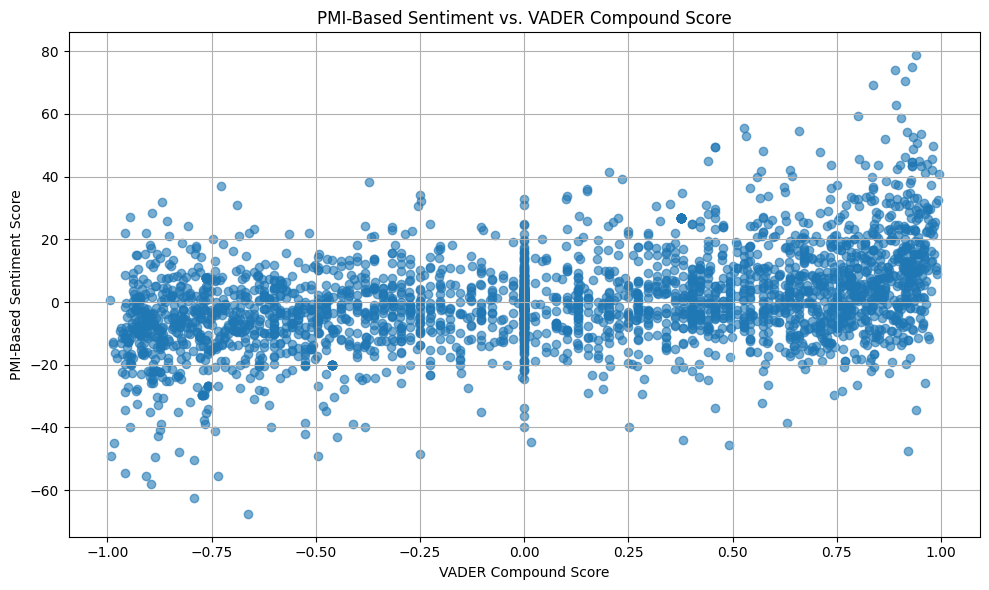

In [ ]:
import re
import math
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# --- Setup ---

# Ensure NLTK resources are available
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Load data
df = pd.read_json("Devon-Boldt-bluesky.json")

# Stopwords setup
stop_words = set(stopwords.words('english'))

# --- Helper Functions ---

def preprocess_text(text):
    """Lowercase, remove non-alphabetic characters, and remove stopwords."""
    text = re.sub(r'[^a-z\s]', '', text.lower())
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

def compute_pmi(word1, word2, word_freq, co_occurrence, total_words, total_pairs):
    """Compute Pointwise Mutual Information (PMI) between two words."""
    if word1 not in word_freq or word2 not in word_freq:
        return 0
    co_occur = co_occurrence[word1][word2]
    if co_occur == 0:
        return 0
    p_w1 = word_freq[word1] / total_words
    p_w2 = word_freq[word2] / total_words
    p_w1w2 = co_occur / total_pairs
    return math.log2(p_w1w2 / (p_w1 * p_w2))

# --- Preprocessing ---

# Clean and tokenize text
df['clean_text'] = df['text'].apply(preprocess_text)
tokenized_tweets = [word_tokenize(tweet) for tweet in df['clean_text']]

# Flatten tokens for frequency count
all_words = [word for tweet in tokenized_tweets for word in tweet]
word_freq = Counter(all_words)

# --- Co-occurrence Matrix ---

window_size = 2
co_occurrence = defaultdict(Counter)

for tweet in tokenized_tweets:
    for i, target in enumerate(tweet):
        window = tweet[max(0, i - window_size): i] + tweet[i + 1: i + 1 + window_size]
        for context_word in window:
            co_occurrence[target][context_word] += 1

total_words = sum(word_freq.values())
total_pairs = sum(sum(c.values()) for c in co_occurrence.values())

# --- PMI-Based Sentiment Scoring ---

positive_seeds = ['good', 'great', 'love', 'happy', 'joy', 'excellent']
negative_seeds = ['bad', 'terrible', 'hate', 'sad', 'awful', 'worst']

pmi_scores = []
for tweet in tokenized_tweets:
    pos_score = sum(compute_pmi(word, seed, word_freq, co_occurrence, total_words, total_pairs)
                    for word in tweet for seed in positive_seeds)
    neg_score = sum(compute_pmi(word, seed, word_freq, co_occurrence, total_words, total_pairs)
                    for word in tweet for seed in negative_seeds)
    pmi_scores.append(pos_score - neg_score)

# --- VADER Sentiment Analysis ---

analyzer = SentimentIntensityAnalyzer()
vader_scores = [analyzer.polarity_scores(text)['compound'] for text in df['text']]

# --- Plotting ---

plt.figure(figsize=(10, 6))
plt.scatter(vader_scores, pmi_scores, alpha=0.6)
plt.title('PMI-Based Sentiment vs. VADER Compound Score')
plt.xlabel('VADER Compound Score')
plt.ylabel('PMI-Based Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()


&nbsp;

&nbsp;